In [49]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach
import bs4 as bs
import matplotlib as mpl
from scipy.stats import linregress
import scipy


def calc_b_with_time_window(dataframe, n_eq, time_window_center):
    df_window = dataframe.copy()
    time_window_index = df_window.index.get_loc(time_window_center, method='pad')
    
    lower_index = time_window_index - n_eq
    if lower_index < 0:
        lower_index = 0
    
#     df_window = df_window.ix[time_window_index - n_eq : time_window_index + n_eq]
    df_window = df_window.ix[lower_index : time_window_index + n_eq]
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_window.mag)
    return a, b, bstd, n, mc, time_window_index

def calc_b_value_for_parameters(dataframe, parameters, location):
    # TODO: will multiprocessing speed this up?
    rows = []
    for r, t in parameters:
        try:
#             for r, t in parameters:
            df_c = polygon_selection.get_node_data(node=location, data=dataframe, radius=r, m=1)
            df_c = df_c.loc[df_c.index >= t]

            a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
            row = np.array((r,) + (t,) + (a, b, bstd, n, mc) + tuple(location))
            rows.append(row)
        except:
            row = np.array((r,) + (t,) +(np.nan, np.nan, np.nan, np.nan, np.nan) + tuple(location))

    return rows

def calc_b_for_parameters_attr_iter(attr):
    dataframe, parameters, location = attr
    return calc_b_value_for_parameters(dataframe, parameters, location)

def plot_beach_ball(earthquake, m, ax, **kwargs):
    lon, lat = earthquake['coordinates']
    x, y = m(lon, lat)
    b = beach(earthquake['focal_mech'], xy=(x, y), **kwargs)
    b.set_zorder(10)
    ax.add_collection(b)
    
def parse_coords(c):
    c = c.replace('\t', '')
    c = c.replace('\n', '')
    c = c.strip()
    c = c.split(' ')
    c = [[float(co) for co in coord.split(',')] for coord in c]
    c = np.array([np.array(co) for co in c])
    return c

def shape_for_scatter_plot(bdf):
    bdf = bdf[bdf.n1 >= 500].copy()
    bdf['years before'] = bdf['t1'].values.astype('datetime64[Y]').astype(int) - 20
    return bdf

def rupture_length(magnitude):
    """
    calculates rupture length using helmstetter relation
    """
    return 0.01 * 10 ** (0.5 * magnitude)

def D_greater_than_calpha(D, alpha, n, m):
    """
    Compares the KS statistic to expected alpha.
    
    Returns True if significant.
    """
    c_alpha = np.sqrt(-0.5 * np.log(alpha/2.))
    D_comparison = c_alpha * np.sqrt( (n + m) / (n * m) )
    if D > D_comparison:
        return True
    else:
        return False

In [5]:
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.3, 'name':'Kumamoto', 'focal_mech':[128  , 71 , -14]}
foreshock1 = {'focal_mech':[299, 79, -10], 'magnitude':6.5, 'coordinates':[130.808667, 32.741667]}
foreshock2 = {'focal_mech':[30, 77, 180], 'magnitude':6.4, 'coordinates':(130.777667, 32.700667)}
rupture_length = rupture_length(7.3)


In [6]:
df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])
eq = kumamoto

df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=3*rupture_length, m=1)
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

soup = bs.BeautifulSoup(open('/home/max/research/kumamoto/data/kyushu_fault.kml'), 'lxml')
fault_coordinates = [parse_coords(tag.text) for tag in soup.findAll('coordinates')]

In [7]:
radii = np.arange(5, (rupture_length * 1.5) + 1, 5)
timii = pd.date_range(start='01-01-1990', end=eq['time'], freq='12M')
radii = np.arange(5, 90, 1)
radii_compare = [ 90,]
depths = np.arange(1, 25, 1)
parameters = [x for x in product(*[radii, radii_compare, timii, depths])]
len(parameters)

55080

In [8]:
def calc_ks_test(params):
#     r1, r2, t1, t2 = params
    r1, r2, t1, d = params
    
    t2 = t1
    
    df1 = df_regional[df_regional.distance <= r1]
    df1 = df1.loc[df1.index >= t1]
    df1 = df1[df1.depth.between(d-1, d+1)]
    
    df2 = df_regional[df_regional.distance <= r2]
    df2 = df2.loc[df2.index >= t2]
    
    a1, b1, bstd1, n1, mc1 = stats.calc_fmd_stats_with_mc(df1.mag)
    a2, b2, bstd2, n2, mc2 = stats.calc_fmd_stats_with_mc(df2.mag)
    
    df1 = df1[df1.mag >= mc1]
    df2 = df2[df2.mag >= mc2]
    
    ks = scipy.stats.ks_2samp(df1.mag, df2.mag)
    
    return r1, r2, d, t1, t2, a1, b1, bstd1, n1, mc1, a2, b2, bstd2, n2, mc2, ks.statistic, ks.pvalue

In [9]:
from multiprocessing import Pool

pool = Pool()

results = pool.map(calc_ks_test, parameters)
pool.close()

/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])
/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])
/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/scipy/stats/stats.py:4750: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/scipy/stats/stats.py:4750: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
/

In [10]:
ks_df = pd.DataFrame(results, columns=['r1', 'r2', 'depth_window', 't1', 't2', 'a1', 'b1', 'bstd1', 'n1', 'mc1'
                                         ,'a2', 'b2', 'bstd2', 'n2', 'mc2'
                                         ,'D', 'p-value'])

In [11]:
# ks_df = ks_df[(ks_df.r1 != ks_df.r2) & (ks_df.t1 != ks_df.t2)]

ks_df['D > c_alpha'] = ks_df.apply(lambda row: D_greater_than_calpha(row['D'], 0.01, row['n1'], row['n2']), axis=1)

ks_df['bdiff'] = ks_df.b1 - ks_df.b2

ks_df['rdiff'] = ks_df.r1 - ks_df.r2

ks_df['pass'] = (ks_df['D > c_alpha']==True) & (ks_df['p-value'] <= 0.01)

In [12]:
ks_df.head()

,r1,r2,depth_window,t1,t2,a1,b1,bstd1,n1,mc1,...,b2,bstd2,n2,mc2,D,p-value,D > c_alpha,bdiff,rdiff,pass
0,5,90,1,1990-01-31,1990-01-31,7.817301,8.685890,NaN,1.0,0.7,...,0.80256,0.003532,46199,0.7,0.583259,0.682103,False,7.883329,-85,False
1,5,90,2,1990-01-31,1990-01-31,NaN,NaN,NaN,NaN,NaN,...,0.80256,0.003532,46199,0.7,NaN,NaN,False,NaN,-85,False
2,5,90,3,1990-01-31,1990-01-31,1.690772,1.737178,1.388182,2.0,0.8,...,0.80256,0.003532,46199,0.7,0.340029,0.924697,False,0.934617,-85,False
3,5,90,4,1990-01-31,1990-01-31,3.441883,2.285760,0.612740,5.0,1.0,...,0.80256,0.003532,46199,0.7,0.590727,0.035292,False,1.483200,-85,False
4,5,90,5,1990-01-31,1990-01-31,2.816359,1.579253,0.283536,12.0,1.0,...,0.80256,0.003532,46199,0.7,0.511937,0.002116,True,0.776692,-85,True


In [58]:
data_for_forest  = shape_for_scatter_plot(ks_df)

In [59]:
data_for_forest = data_for_forest[['r1', 'depth_window', 'years before', 'b1', 'n1']].copy()

In [60]:

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from scipy.stats import norm, sem, t

In [115]:
clf = RandomForestRegressor(n_estimators=2)

In [141]:
train = data_for_forest.sample(frac=0.05)
test = data_for_forest.iloc[~data_for_forest.index.isin(train.index)]

In [142]:
X = train[['r1', 'depth_window', 'years before', 'n1']]
# y = pd.factorize(train['b1'])

In [143]:
clf.fit(X, train['b1'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [144]:
predict = clf.predict(test[['r1', 'depth_window', 'years before', 'n1']])

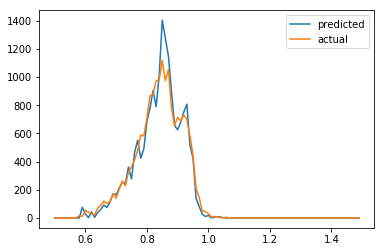

In [145]:
h, e = np.histogram(a=predict, bins=100, range=(0.5, 1.5))

plt.plot(e[:-1], h, label='predicted')

h2, e2 = np.histogram(a=test.b1, bins=100, range=(0.5, 1.5))

plt.plot(e2[:-1], h2, label='actual')

plt.legend()

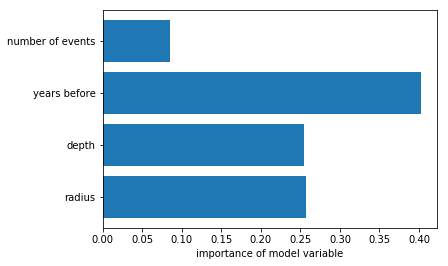

In [147]:
fig, ax = plt.subplots()
ax.barh(range(len(clf.feature_importances_)), clf.feature_importances_)

ax.set_yticks(range(len(clf.feature_importances_)))
ax.set_yticklabels(['radius', 'depth', 'years before', 'number of events'])

ax.set_xlabel('importance of model variable')

In [84]:
train.b1.shape

(3748,)

In [79]:
X.shape

(3748, 4)

In [81]:
y

(array([   0,    1,    2, ..., 3734, 3735, 3736]),
 Float64Index([0.877390313984, 0.960957877213, 0.930539379177, 0.831851550953,
               0.812929718473, 0.848637652827, 0.665241954898, 0.822818512604,
               0.827784688874, 0.900309720809,
               ...
                0.80032347945, 0.855428524961, 0.878966850297, 0.853951276868,
                0.85428445989, 0.948641074338, 0.796626959573,  0.84124064622,
               0.862964979692, 0.883935762846],
              dtype='float64', length=3737))